## 1. SOTA-модели и подходы

Описание проекта:  
https://colab.research.google.com/drive/1wGRAB_n26dHi5NRbkx91mlMC7CO8cVYk?usp=sharing#scrollTo=Zc1eyTTDq51T  
  
Face recogtinion pipeline clearly explained (medium):

 https://medium.com/backprop-labs/face-recognition-pipeline-clearly-explained-f57fc0082750

Face landmark detection using PyTorch:

  https://towardsdatascience.com/face-landmarks-detection-with-pytorch-4b4852f5e9c4

Face detection in Python:  
https://machinelearningmastery.com/how-to-perform-face-detection-with-classical-and-deep-learning-methods-in-python-with-keras/

Пример метрики для подсчета качества систем распознавания лиц:

 http://www.eecs.qmul.ac.uk/~sgg/papers/ChengEtAl_PR2020.pdf (секция 3.2.3)

## Примеры кода
- с библиотекой face recognition  
comapare two faces whether those belong to one persone or not  
https://github.com/rjcoder86/Face-Recognition/tree/main  
-  с библиотекой face recognition   
https://realpython.com/face-recognition-with-python/


## О трансформерах  
https://habr.com/ru/articles/666314/  
https://education.yandex.ru/handbook/ml/article/transformery  
https://github.com/lucidrains/vit-pytorch простой код на pytorch

## 2. Загрузка и обработка данных

Библиотеки для декодирования видео: OpenCV, FFmpeg, GStreamer

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from PIL import Image
from skimage.io import imread, imshow
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms


Загрузим фотографии лиц, которые уже заранее выровнены.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

!unzip -q /content/gdrive/MyDrive/celebA_train_500.zip
!rm -r __MACOSX
!ls celebA_train_500

Mounted at /content/gdrive/
celebA_anno.txt  celebA_imgs  celebA_train_split.txt


Содержимое папки с данными:

        - celebA_imgs — папка с выровненными картинками;
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;
        - celebA_train_split.txt — файл со сплитом на train/val/test

In [ ]:
!ls celebA_train_500/celebA_imgs | head

000001.jpg
000002.jpg
000003.jpg
000004.jpg
000005.jpg
000006.jpg
000007.jpg
000008.jpg
000009.jpg
000010.jpg


Посмотрим на фотографии лиц

Количество всех фото: 23948
Размер одного изображения: (218, 178, 3)


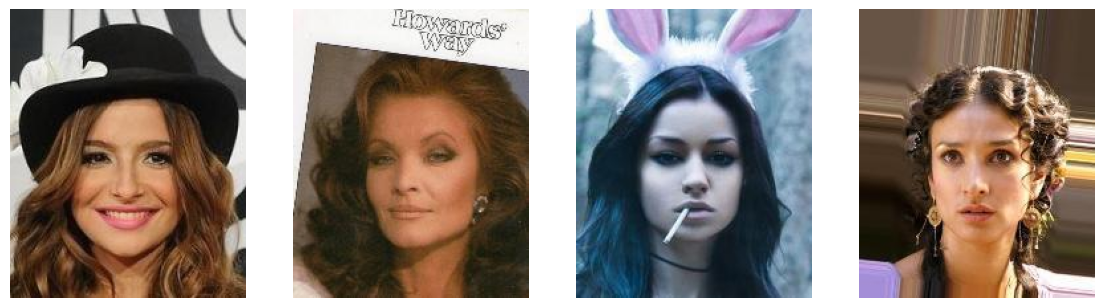

In [ ]:
DATA_DIR = './celebA_train_500/celebA_imgs'

files = os.listdir(DATA_DIR)
files_path = [os.path.join(DATA_DIR, file) for file in files]
images = [imread(file) for file in files_path[:4]]

fig, axes = plt.subplots(1, 4, figsize=(14, 4))
for ax, image in zip(axes, images):
    ax.imshow(image)
    ax.axis('off')

print('Количество всех фото:', len(files))
print('Размер одного изображения:', images[0].shape)

In [ ]:
RESCALE_SIZE = 224

class FaceDataset(Dataset):
    """
    Датасет с лицами, который паралельно подгружает их из папок
    и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        self.len_ = len(self.files)

    def __len__(self):
        return self.len_

    def _prepare_sample(self, file):
        # load
        image = np.array(Image.open(file))
        # crope and resize
        image = Image.fromarray(image[77:-41, 45:-50])
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return image

    def __getitem__(self, index):
        if self.mode == 'train':
            # change brightness and flip
            transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ColorJitter(brightness=0.3,
                                       contrast=0.3,
                                       saturation=0.3,
                                       hue=0.1),
                transforms.ToTensor(),
                # transforms.Normalize(),
                ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                # transforms.Normalize(),
                ])

        x = self._prepare_sample(self.files[index])
        x = transform(x)

        filename = os.path.basename(self.files[index])
        y = df_anno[df_anno['filename'] == filename]['label']
        y = y.iloc[0]

        return x, y


In [ ]:
df_anno = pd.read_csv("celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_split = pd.read_csv("celebA_train_500/celebA_train_split.txt", header=None, sep=' ')

df_split.columns = ['filename', 'split']
df_anno.columns = ['filename', 'label']

df_anno['filename'].equals(df_split['filename'])

True

In [ ]:
# Аннотация к картинке
df_anno.sample(5)

,filename,label
1261,128935.jpg,47
4848,068784.jpg,191
3877,007965.jpg,153
1794,142871.jpg,68
7789,137544.jpg,320


In [ ]:
# Принадлежность к выборке
# train (0), test (1), val (2)
df_split.sample(5)

,filename,split
6026,093418.jpg,0
11525,020002.jpg,0
972,032277.jpg,0
8886,094162.jpg,0
1303,068634.jpg,0


In [ ]:
# Списки названий train, test и val файлов
train_files = df_split[df_split['split'] == 0]['filename'].tolist()
test_files = df_split[df_split['split'] == 1]['filename'].tolist()
val_files = df_split[df_split['split'] == 2]['filename'].tolist()

# Списки путей к train, test и val файлам
train_files = [os.path.join(DATA_DIR, file) for file in train_files]
test_files = [os.path.join(DATA_DIR, file) for file in test_files]
val_files = [os.path.join(DATA_DIR, file) for file in val_files]

print(len(train_files))
print(len(test_files))
print(len(val_files))

8544
1878
1589


In [ ]:
batch_size = 32

# Dataset
train_dataset = FaceDataset(train_files, mode='train')
val_dataset = FaceDataset(val_files, mode='val')
test_dataset = FaceDataset(test_files, mode='test')

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## 3. Детекция лица (face detection)

## 4. Выравнивание лица (face alignment)

## 5. Распознавание лица (face recognition)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(train_loader, val_loader,
          model, criterion, optimizer, epochs):

    train_losses = []
    val_losses = []
    scores_train = []
    scores_val = []

    for epoch in range(epochs):
        print('\nEpoch %d/%d ...' % (epoch+1, epochs))

        model.train()
        avg_train_loss = 0
        true_train_labels = 0
        n_train_samples = 0

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            preds = torch.argmax(outputs, dim=1)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            avg_train_loss += loss.item() * y_batch.size(0)
            true_train_labels += torch.sum(preds == y_batch)
            n_train_samples += y_batch.size(0)

        train_loss = avg_train_loss / n_train_samples
        train_losses.append(train_loss)
        print('train loss: %f' % train_loss)

        model.eval()
        train_accuracy = true_train_labels.cpu().numpy() / n_train_samples
        scores_train.append(train_accuracy)

        avg_val_loss = 0
        true_val_labels = 0
        n_val_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                outputs = model(X_batch)
                preds = torch.argmax(outputs, dim=1)
                loss = criterion(outputs, y_batch)

                avg_val_loss += loss.item() * y_batch.size(0)
                true_val_labels += torch.sum(preds == y_batch)
                n_val_samples += y_batch.size(0)

        val_loss = avg_val_loss / n_val_samples
        val_losses.append(val_loss)
        val_accuracy = true_val_labels.cpu().numpy() / n_val_samples
        scores_val.append(val_accuracy)

        print('val_loss: %f' % val_loss)

    X_batch.to('cpu')
    del X_batch
    torch.cuda.empty_cache()

    return train_losses, val_losses, scores_train, scores_val

#### ResNet

In [ ]:
n_classes = 500
resnet = models.resnet34(pretrained=True)

# Замораживаем параметры
for param in resnet.parameters():
    param.requires_grad = False

# Заменяем Fully-Connected слой в ResNet
embeddings = resnet.fc.in_features
resnet.fc = nn.Linear(embeddings, n_classes)
resnet.to(device)

In [ ]:
# Обучаем только последний cлой-классификатор

n_epochs = 6
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.fc.parameters(), lr=1e-3)
history_1 = train(train_loader, val_loader, resnet, criterion, optimizer, epochs=n_epochs)


Epoch 1/6 ...
train loss: 6.384790
val_loss: 5.500278

Epoch 2/6 ...
train loss: 5.325312
val_loss: 4.747657

Epoch 3/6 ...
train loss: 4.724341
val_loss: 4.159482

Epoch 4/6 ...
train loss: 4.242601
val_loss: 3.731865

Epoch 5/6 ...
train loss: 3.926342
val_loss: 3.465176

Epoch 6/6 ...
train loss: 3.606008
val_loss: 3.181905


In [ ]:
# Размораживаем все параметры
for param in resnet.parameters():
    param.requires_grad = True

n_epochs = 3
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)
history_2 = train(train_loader, val_loader, resnet, criterion, optimizer, epochs=n_epochs)


Epoch 1/3 ...
train loss: 2.338803
val_loss: 1.205057

Epoch 2/3 ...
train loss: 1.169838
val_loss: 0.616804

Epoch 3/3 ...
train loss: 0.627132
val_loss: 0.317510


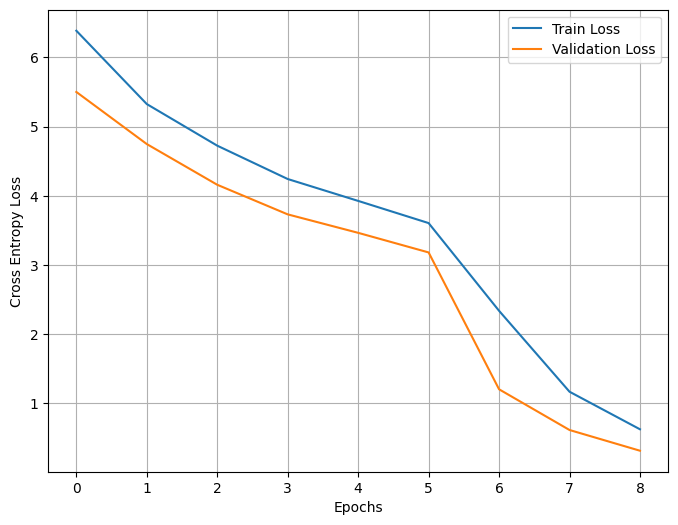

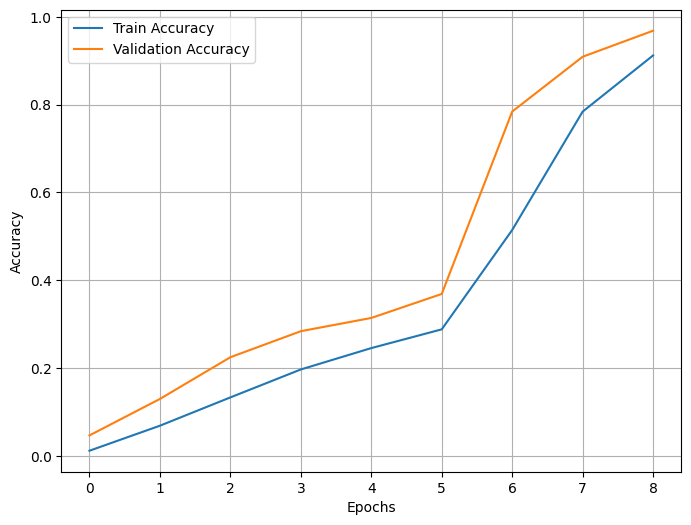

In [ ]:
# Графики

# Объединяем history
train_losses_1, val_losses_1, scores_train_1, scores_val_1 = history_1
train_losses_2, val_losses_2, scores_train_2, scores_val_2 = history_2

train_losses = train_losses_1 + train_losses_2
val_losses = val_losses_1 + val_losses_2
scores_train = scores_train_1 + scores_train_2
scores_val = scores_val_1 + scores_val_2

# Лоссы
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross Entropy Loss')
plt.title('ResNet 34')
plt.legend()
plt.grid(True)
plt.show()

# Accuracy
plt.figure(figsize=(8, 6))
plt.plot(scores_train, label='Train Accuracy')
plt.plot(scores_val, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Рекомендация из комментариев:  
1. Узнать количество признаков последнего полносвязного слоя  
2. Удалить последний поносвязный слой  
3. Заморозить параметры всех оставшихся слоев  
4. Добавить пару новых полносвязных слоев  
5. Дропаут  

EfficientNet

In [ ]:
del resnet

In [10]:
models_list = [
    models.efficientnet_v2_s,
    models.efficientnet_v2_m,
    models.efficientnet_v2_l,
]

# Последний слой efficient
models_list[0](pretrained=True).classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [ ]:
for model in models_list:
    efficientnet = model(pretrained=True)

    # Обучаем только последний слой

    for param in efficientnet.parameters():
        param.requires_grad = False

    embeddings = efficientnet.classifier[1].in_features
    efficientnet.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(embeddings, n_classes)
    )
    efficientnet.to(device)

    n_epochs = 6
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(efficientnet.classifier.parameters(), lr=1e-3)
    history_1 = train(train_loader, val_loader, efficientnet, criterion, optimizer, epochs=n_epochs)

    # Обучаем всю сеть

    for param in efficientnet.parameters():
        param.requires_grad = True

    n_epochs = 3
    optimizer = torch.optim.Adam(efficientnet.parameters(), lr=1e-4)
    history_2 = train(train_loader, val_loader, efficientnet, criterion, optimizer, epochs=n_epochs)

    # Графики